In [1]:
import os
import re
import nltk
import string

import tensorflow as tf
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import twitter_samples 

nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/vikash/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vikash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# select the set of positive and negative tweets
positive_tweet_list = twitter_samples.strings('positive_tweets.json')
negative_tweet_list = twitter_samples.strings('negative_tweets.json')

print("All positive tweets length: ", len(positive_tweet_list))
print("All negative tweets length: ", len(negative_tweet_list))

All positive tweets length:  5000
All negative tweets length:  5000


In [3]:
# preprocess tweet
stemmer = PorterStemmer()
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

stopwords_eng = stopwords.words("english")
punctuations_eng = string.punctuation


In [4]:
def preprocess_tweet(tweet):
    # remove stock market tickers like $GE
    tweet = re.sub(r"\$\w*", "", tweet)
    
    # remove old style retweet text "RT"
    tweet = re.sub(r"^RT[\s]+", "", tweet)
    
    # remove hyperlinks
    tweet = re.sub(r"https?:\/\/[.a-zA-Z\/-]*[\r\n]*", "", tweet)
    
    # remove the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    tweet_tokens = tokenizer.tokenize(tweet)
    
    tweet_tokens_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_eng and word not in punctuations_eng):
            stemmed_word = stemmer.stem(word)
            
            tweet_tokens_clean.append(stemmed_word)
    
    return tweet_tokens_clean

In [5]:
"""
Lets generate word cloud.
Word Cloud is a data visualization technique used for 
representing text data in which the size of each word 
indicates its frequency or importance. Significant textual 
data points can be highlighted using a word cloud.
"""
# word cloud for tweets 
def generate_word_cloud(tweet_list):
    tweets = ""
    for tweet in tweet_list:
        tweet_tokens = preprocess_tweet(tweet)
        tweets += " ".join(tweet_tokens) + " "
        
    wordcloud = WordCloud(width = 2500, height = 2500, 
                background_color ='white', 
                stopwords = stopwords_eng, 
                min_font_size = 10).generate(tweets) 
    
    # plot the WordCloud image                        
    plt.figure(figsize = (15, 15), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

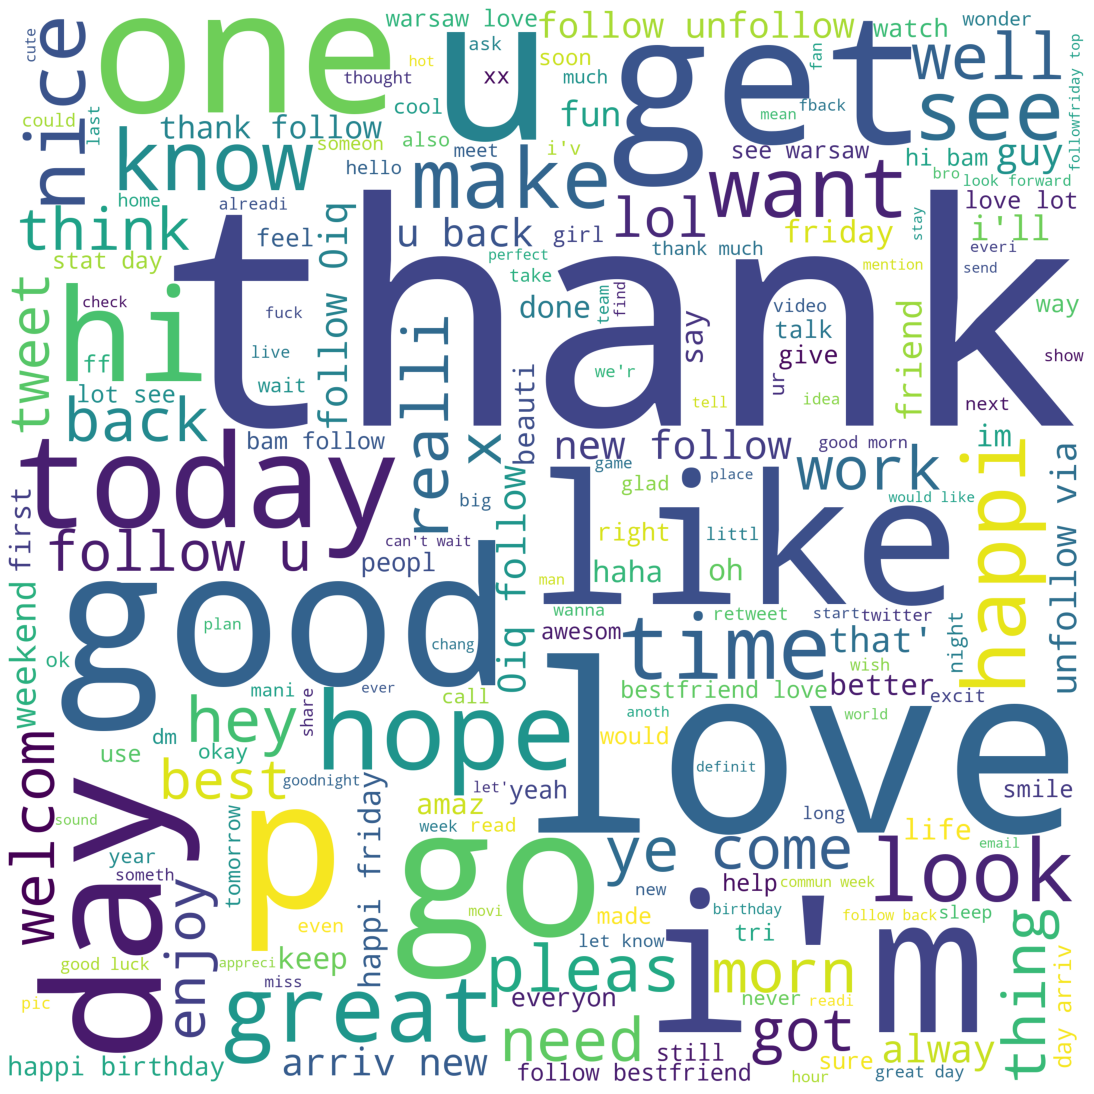

In [6]:
#for positive tweets
generate_word_cloud(positive_tweet_list)

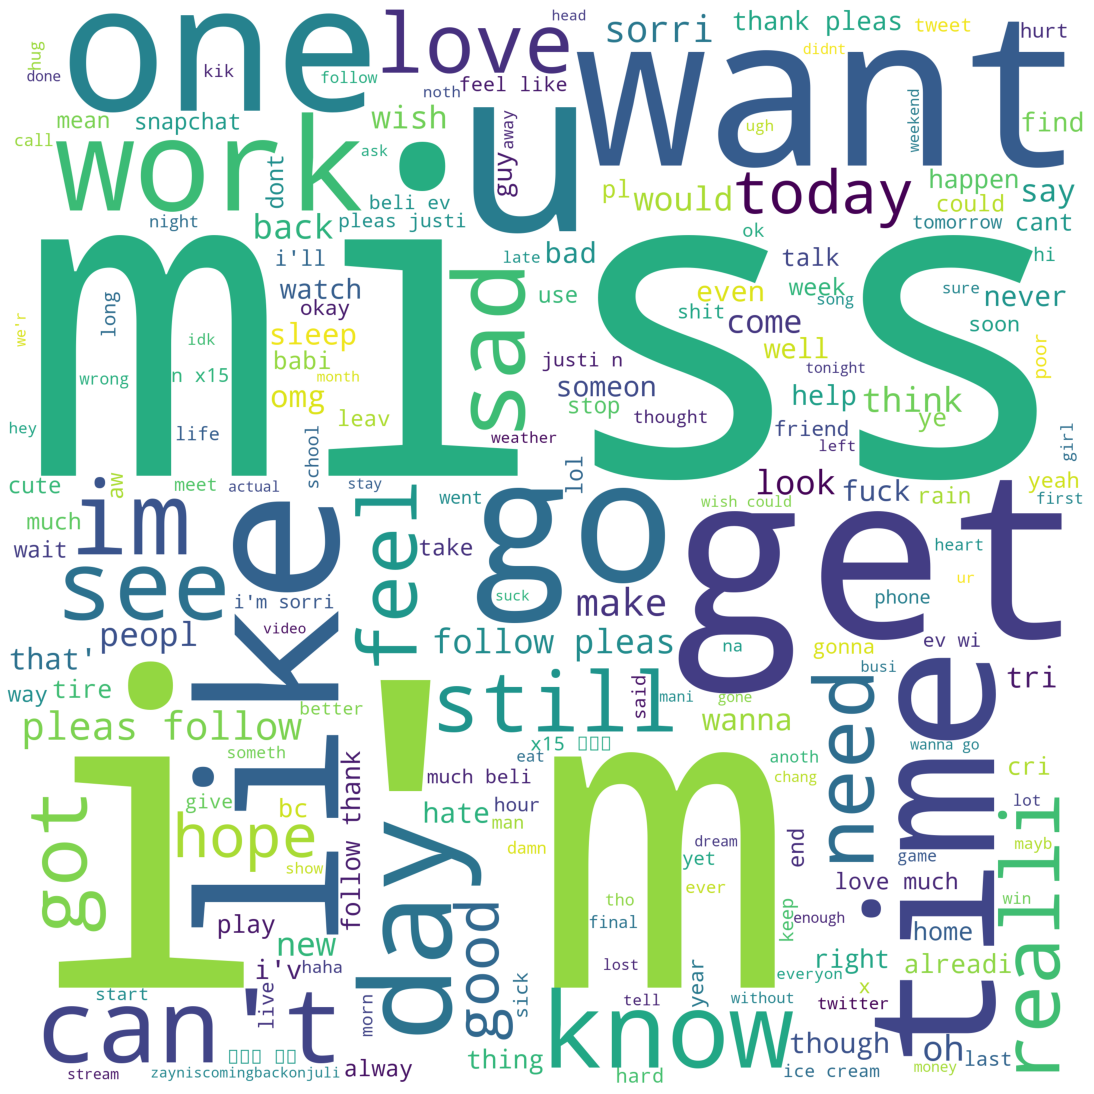

In [7]:
# for negative tweets
generate_word_cloud(negative_tweet_list)

In [8]:
# get word frequencies

def generate_words_frequency(tweet_list):
    frequency_dict = {}
    for tweet in tweet_list:
        tweet_tokens = preprocess_tweet(tweet)
        for word in tweet_tokens:
            if word not in frequency_dict:
                frequency_dict[word] = 1
            else:
                frequency_dict[word] += 1
                
    return frequency_dict

In [9]:
positive_word_frequency_dict = generate_words_frequency(positive_tweet_list)
negative_word_frequency_dict = generate_words_frequency(negative_tweet_list)

In [25]:
def generate_bar_graph(frequency_dict, g_type="positive"):
    
    frequency_list = [(k, v) for k, v in frequency_dict.items()]
    print(frequency_list[:10])
    frequency_list = sorted(frequency_list, key= lambda x: x[1], reverse=True)
    
    print(frequency_list[:10])
    
    # get top 20
    top_20_words = [word[0] for word in frequency_list[:20]]
    top_20_counts = [word[1] for word in frequency_list[:20]]
    
    fig = plt.figure(figsize = (15, 10)) 
  
    # creating the bar plot 
    plt.bar(top_20_words, top_20_counts, color ='maroon',  
            width = 0.4) 

    plt.xlabel("Top Words") 
    plt.ylabel("frequency") 
    plt.title("words appearing in {}".format(g_type)) 
    plt.show() 

[('followfriday', 25), ('top', 32), ('engag', 7), ('member', 16), ('commun', 33), ('week', 83), (':)', 3691), ('hey', 77), ('jame', 7), ('odd', 2)]
[(':)', 3691), (':-)', 701), (':D', 658), ('thank', 643), ('follow', 447), ('love', 401), ('...', 290), ('day', 246), ('u', 245), ('good', 238)]


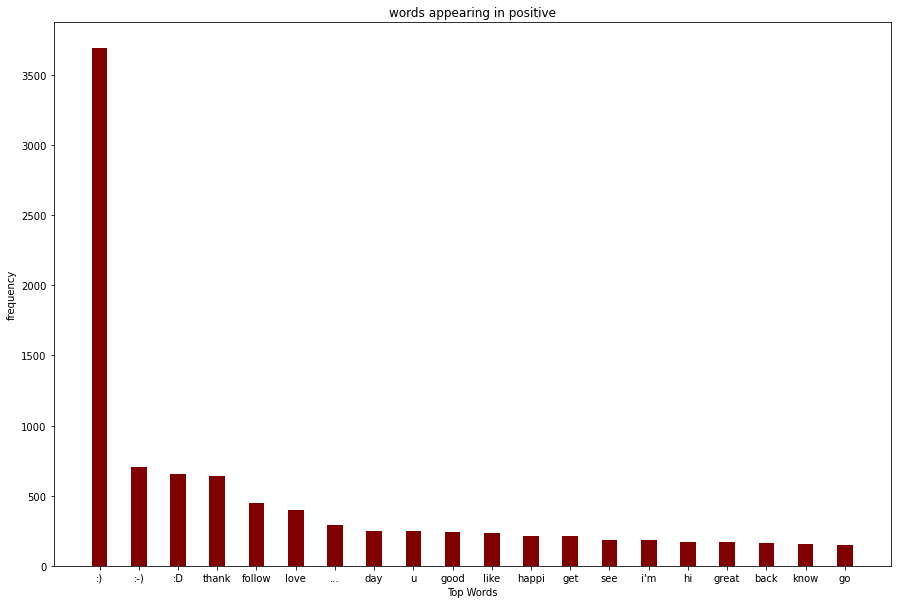

In [26]:
generate_bar_graph(positive_word_frequency_dict, g_type="positive")

[('hopeless', 2), ('tmr', 3), (':(', 4585), ('everyth', 17), ('kid', 20), ('section', 3), ('ikea', 1), ('cute', 43), ('shame', 19), ("i'm", 343)]
[(':(', 4585), (':-(', 501), ("i'm", 343), ('...', 332), ('miss', 301), ('pleas', 275), ('follow', 263), ('want', 246), ('get', 233), ('like', 228)]


/home/vikash/miniconda3/envs/tensorflow/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12299 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/vikash/miniconda3/envs/tensorflow/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 12299 missing from current font.
  font.set_text(s, 0, flags=flags)


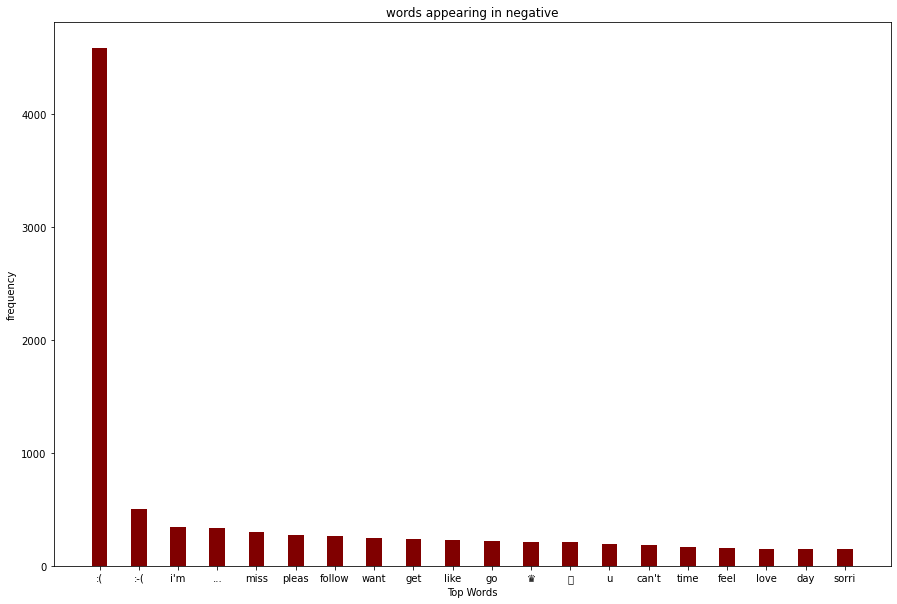

In [27]:
generate_bar_graph(negative_word_frequency_dict, g_type="negative")

In [38]:
train_pos, test_pos = positive_tweet_list[:4000], positive_tweet_list[4000:]
train_neg, test_neg = negative_tweet_list[:4000], negative_tweet_list[4000:]

pos_frequency_dict = generate_words_frequency(train_pos)
neg_frequency_dict = generate_words_frequency(train_neg)

In [39]:
def extract_features(tweet, pos_freq_dict, neg_freq_dict):
    tweet_tokens = preprocess_tweet(tweet)
    x = np.zeros((1, 3))
    # bias
    x[0, 0] = 1
    
    for word in tweet_tokens:
        x[0, 1] += pos_freq_dict.get(word, 0)
        x[0, 2] += neg_freq_dict.get(word, 0)
        
    return x

In [41]:
train_x = train_pos + train_neg
test_x = test_pos + test_neg

# collect the features and stack them in mattrix X
train_X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    train_X[i, :] = extract_features(train_x[i], pos_frequency_dict, neg_frequency_dict)

test_X = np.zeros((len(test_x), 3))
for i in range(len(test_x)):
    test_X[i, :] = extract_features(test_x[i], pos_frequency_dict, neg_frequency_dict)

train_Y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg))).reshape(len(train_pos)+len(train_neg), -1)
test_Y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg))).reshape(len(test_pos)+len(test_neg), -1)

train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

((8000, 3), (2000, 3), (8000, 1), (2000, 1))

In [44]:
# logistic regression

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [51]:
def get_cost(y, y_out, m):
    return -1/m * (np.dot(y.transpose(), np.log(y_out)) + 
                  np.dot((1-y).transpose(), np.log(1-y_out)))

In [69]:
def train(x, y, theta, lr, num_iter=700):
    """
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    """
    print(x.shape, y.shape, theta.shape)
    m = x.shape[0]
    
    for idx in range(num_iter):
        z = np.dot(x, theta)
        
        y_out = sigmoid(z)
        
        cost = get_cost(y, y_out, m)
        
        gradient = np.dot(x.transpose(), (y_out - y)) / m
        
        theta = theta - lr * gradient
        
        if (idx + 1) % 50 == 0:
            print("The cost after iteration {}: {}".format(idx + 1, float(cost)))
        
    print("The final weight = {}".format(np.squeeze(theta)))
    
    return theta
    
final_weight = train(train_X, train_Y, np.zeros((3, 1)), 1e-9, num_iter=1500)

(8000, 3) (8000, 1) (3, 1)
The cost after iteration 50: 0.6414308668582142
The cost after iteration 100: 0.5959732086207035
The cost after iteration 150: 0.5566345700118238
The cost after iteration 200: 0.5223548213790135
The cost after iteration 250: 0.4922799958090386
The cost after iteration 300: 0.4657257073269875
The cost after iteration 350: 0.44214122075114665
The cost after iteration 400: 0.42108021118641364
The cost after iteration 450: 0.4021781425144818
The cost after iteration 500: 0.38513496598968217
The cost after iteration 550: 0.3697018704742352
The cost after iteration 600: 0.35567107721947444
The cost after iteration 650: 0.34286792222261886
The cost after iteration 700: 0.3311446656188963
The cost after iteration 750: 0.3203756136333207
The cost after iteration 800: 0.3104532454788448
The cost after iteration 850: 0.30128511554925846
The cost after iteration 900: 0.29279135828013975
The cost after iteration 950: 0.28490266497190253
The cost after iteration 1000: 0.27

In [85]:
# evaluate performence
def get_accuracy(x, y, final_weight):
    z = np.dot(x, final_weight)
        
    y_out = sigmoid(z)
    
    y_pred = np.zeros((y.shape[0], 1))
    for idx in range(y.shape[0]):
        if y_out[idx, 0] >= 0.5:
            y_pred[idx, 0] = 1
    
    correct = np.sum(y_pred == y)
    
    return correct*100/x.shape[0]
    
    
accuracy = get_accuracy(test_X, test_Y, final_weight)
print(f"The test accuracy is {accuracy:.1f}%")

The test accuracy is 99.5%


In [83]:
# Predict new tweets
def predict_tweet(tweet_list, pos_freq_dict, neg_freq_dict, final_weights):
    X = np.zeros((len(tweet_list), 3))
    for i in range(len(tweet_list)):
        X[i, :] = extract_features(tweet_list[i], pos_frequency_dict, neg_frequency_dict)
        
    y_pred = sigmoid(np.dot(X,final_weights))
    
    res = []
    for i in range(len(tweet_list)):
        if y_pred[i, 0] >= 0.5:
            print(f"{tweet_list[i]}: Positive Sentiment")
        else:
            print(f"{tweet_list[i]}: Negative Sentiment")
        
    return y_pred

tweets = ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']
predict_tweet(tweets, pos_frequency_dict, neg_frequency_dict, final_weight)

I am happy: Positive Sentiment
I am bad: Negative Sentiment
this movie should have been great.: Positive Sentiment
great: Positive Sentiment
great great: Positive Sentiment
great great great: Positive Sentiment
great great great great: Positive Sentiment


array([[0.51927725],
       [0.494346  ],
       [0.51598138],
       [0.51606681],
       [0.53210047],
       [0.5480681 ],
       [0.56393739]])

In [86]:
tweets = ['I am happy']
predict_tweet(tweets, pos_frequency_dict, neg_frequency_dict, final_weight)

I am happy: Positive Sentiment


array([[0.51927725]])